In [1]:
import os
from os import listdir
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten,Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

C:\Users\Rupa\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Here 0 means Cat and 1 means Dog
genuine = 1
forged = 0
#Returns whether the low memory mode is used.
IS_LOW_MEMORY_MODE = True
#current working directory of a process.
cwd = os.getcwd()
#This method is called when RandomState is initialized
np.random.seed(2124)
ROWS = 32
COLS = 32

In [3]:
genuine_image_paths = "Signature/genuine"
forged_image_paths = "Signature/forged"

In [4]:
genuine_image_filenames = listdir(genuine_image_paths)
forged_image_filenames = listdir(forged_image_paths)

In [5]:
genuine_dir_list = []
genuine_labels = []
for i, d in enumerate(genuine_image_filenames):
    genuine_labels.append(genuine)
    genuine_dir_list.append(os.path.join(genuine_image_paths, d))    

In [6]:
forged_dir_list = []
forged_labels = []
for i, d in enumerate(forged_image_filenames):
    forged_labels.append(forged)
    forged_dir_list.append(os.path.join(forged_image_paths, d))    

In [7]:
genuine_img_list = []
for i, d in enumerate(genuine_dir_list):    
    raw_image = cv2.imread(d,cv2.IMREAD_COLOR) 
    b,g,r = cv2.split(raw_image)
    raw_image = cv2.merge([r,g,b])   
    resize_img = cv2.resize(raw_image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    resize_img = resize_img.astype('float32')
    resize_img /= 255
    genuine_img_list.append(resize_img)

In [8]:
forged_img_list = []
for i, d in enumerate(forged_dir_list):
    raw_image = cv2.imread(d,cv2.IMREAD_COLOR)     
    b,g,r = cv2.split(raw_image)
    raw_image = cv2.merge([r,g,b])
    resize_img = cv2.resize(raw_image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    resize_img = resize_img.astype('float32')
    resize_img /= 255
    forged_img_list.append(resize_img)

In [9]:
def genuine_and_forged_img(idx):
    genuine_img = genuine_img_list[idx]
    forged_img = forged_img_list[idx]
    pair = np.concatenate((genuine_img, forged_img), axis=1)
    plt.figure(figsize=(8,2))
    plt.imshow(pair)
    plt.show()

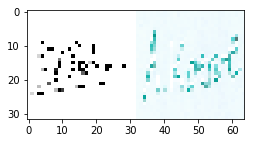

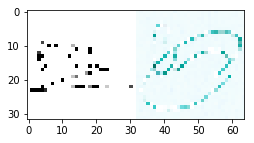

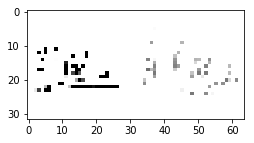

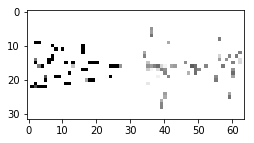

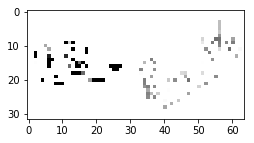

In [10]:
for idx in range(0,5):
    genuine_and_forged_img(idx)

In [11]:
image_list = genuine_img_list+forged_img_list
label_list = genuine_labels+forged_labels

In [12]:
len(image_list),len(label_list)

(300, 300)

In [13]:
image_list = np.array(image_list)
image_list.shape

(300, 32, 32, 3)

In [14]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
train, test, train_val,test_val = train_test_split(image_list,label_list, test_size=0.2, random_state=1)

In [15]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (240, 32, 32, 3)
Test shape: (60, 32, 32, 3)


In [16]:
# Find the unique numbers from the train labels
classes = np.unique(train_val)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [17]:
def createModel():
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=train.shape[1:], activation='relu'))
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("First layer...")
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Second layer...")
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Third layer...")
    model.add(Conv2D(256, 3, padding='same', activation='relu'))
    model.add(Conv2D(256, 3, padding='same', activation='relu'))
    model.add(Conv2D(256, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))    
    #print("Flattening, etc...")
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [18]:
model = createModel()
batch_size = 16
epochs = 50
optimizer = 'adam'
objective = 'binary_crossentropy'
model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 16, 64)        9280      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 8, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 8, 128)        36992     
__________

In [20]:
history = model.fit(train, train_val, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(test, test_val))

Train on 240 samples, validate on 60 samples
Epoch 1/50
240/240 [==============================] - 15s 62ms/step - loss: 0.7439 - acc: 0.5000 - val_loss: 0.6944 - val_acc: 0.4667
Epoch 2/50
240/240 [==============================] - 11s 47ms/step - loss: 0.6927 - acc: 0.5292 - val_loss: 0.6933 - val_acc: 0.4667
Epoch 3/50
240/240 [==============================] - 11s 48ms/step - loss: 0.6948 - acc: 0.4625 - val_loss: 0.6943 - val_acc: 0.4667
Epoch 4/50
240/240 [==============================] - 12s 50ms/step - loss: 0.6933 - acc: 0.5042 - val_loss: 0.6946 - val_acc: 0.4667
Epoch 5/50
240/240 [==============================] - 12s 48ms/step - loss: 0.6927 - acc: 0.5042 - val_loss: 0.6939 - val_acc: 0.4667
Epoch 6/50
240/240 [==============================] - 11s 45ms/step - loss: 0.6926 - acc: 0.5292 - val_loss: 0.6943 - val_acc: 0.4667
Epoch 7/50
240/240 [==============================] - 11s 45ms/step - loss: 0.6952 - acc: 0.4750 - val_loss: 0.6927 - val_acc: 0.5333
Epoch 8/50
240/24

In [21]:
model.evaluate(test, test_val)

60/60 [==============================] - 1s 19ms/step


[0.6944817622502645, 0.4666666626930237]

In [26]:
predictions = model.predict(test, verbose=2)

In [28]:
predictions[0]

array([0.5088367], dtype=float32)

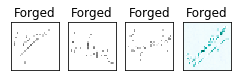

In [23]:
fig=plt.figure()

for index in range(4):
    # cat: [1,0]
    # dog: [0,1]
    y = fig.add_subplot(1,6,index+1)
    #model_out = model.predict([data])[0]
    img = test[index]    
    model_out = predictions[index]
    if np.argmax(model_out) == 0: str_label='Forged'
    else: str_label='Genuine'
        
    y.imshow(img)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()